# 分析MIDI数据和可视化展示——以巴赫圣母颂为例

#### 161070073 吴欣宜   ，               161090090 闵瑞瑜        2019.12

# 一、mid文件处理

In [1]:

# Main mode
import pretty_midi # for .mid
import numpy as np
# For plot
import mir_eval.display
import librosa.display
import matplotlib.pyplot as plt
# For play
import IPython.display

In [2]:
pm=pretty_midi.PrettyMIDI('prelude1Try.mid')#open .mid
IPython.display.Audio(pm.synthesize(fs=16000),rate=16000)#play .mid

/opt/anaconda3/lib/python3.7/site-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  RuntimeWarning)


## （一）音频信息可视化
- 音频总时长
- 音频节奏变化判断
- 音频钢琴滚动分布图：把midi文件用二维的方式画出来
- 找出最高音和最低音
- 演示写入新的pretty_midi事件，并实现播放（最高音和最低音、两只老虎开头）

### 1、音频总时长  
**pretty_midi.PrettyMIDI.get_end_time( )**  
Returns the time of the end of the MIDI object (time of the last event in all instruments/meta-events).  

In [3]:
pm=pretty_midi.PrettyMIDI('prelude1Try.mid')#打开mid文件
allnotes_ends=pm.get_end_time()#pretty_midi.PrettyMIDI的内建函数，返回值是时间，单位是s或者小节数
print("这首曲子的小节数为{}个".format(allnotes_ends))#曲子总时长

这首曲子的小节数为70.0个


### 2. 音频节奏变化判断 
**pretty_midi.PrettyMIDI.estimate_tempi( )**  
Return an empirical estimate of tempos and each tempo’s probability. Based on “Automatic Extraction of Tempo and Beat from Expressive Performance”, Dixon 2001.    

**pretty_midi.PrettyMIDI.estimate_tempo( )**  
Returns the best tempo estimate from pretty_midi.PrettyMIDI.estimate_tempi(), for convenience. 为了方便起见，从上述函数（tempi）返回最佳速度估计，单位是bpm    
（BPM是Beat Per Minute的简称，中文名为拍子数，释义为每分钟节拍数的单位。最浅显的概念就是在一分钟的时间段落之间，所发出的声音节拍的数量，这个数量的单位便是BPM。也叫做拍子数。）  

**pretty_midi.PrettyMIDI.get_tempo_changes( )**  
Return arrays of tempo changes in quarter notes-per-minute and their times. 返回每分钟**四分音符**和其在tempo_change_times中每个时间点的速度变化数组。  

这首曲子节奏为每分钟[120.]拍，全程没有发生节奏变化


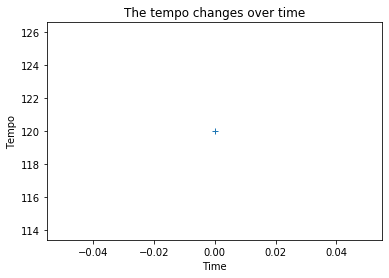

In [4]:
times, tempo_changes = pm.get_tempo_changes() #(array([0.]), array([120.]))
#返回的是第一个数组是tempo变化的时间点，第二个数组是在那个tempo变化的时间点上的速度
plt.plot(times, tempo_changes, '+')
plt.title('The tempo changes over time')
plt.xlabel('Time')
plt.ylabel('Tempo')
if(pm.get_tempo_changes()[0]==[0]):#内建函数返回的是tempo变化的时间点
    print("这首曲子节奏为每分钟{}拍，全程没有发生节奏变化".format(pm.get_tempo_changes()[1]))
else:
    print("这首曲子节奏发生了变化")
plt.show()

### 3. 音频钢琴滚动分布图: 把midi文件用二维的方式画出来
**pretty_midi.PrettyMIDI.get_piano_roll(fs=100, times=None)**  
Compute a piano roll matrix of the MIDI data. 计算MIDI数据的钢琴滚动矩阵  
Parameters:  
fs : int  
Sampling frequency of the columns, i.e. each column is spaced apart by 1./fs seconds.    

**音频处理库librosa里的频谱显示函数specshow( )**  
librosa.display.specshow(data, x_coords=None, y_coords=None, x_axis=None, y_axis=None, sr=22050, hop_length=512, fmin=None, fmax=None, tuning=0.0, bins_per_octave=12, ax=None, **kwargs)  

**Notes have a pitch number from 0 to 127, representing the notes from C-1 to G9**

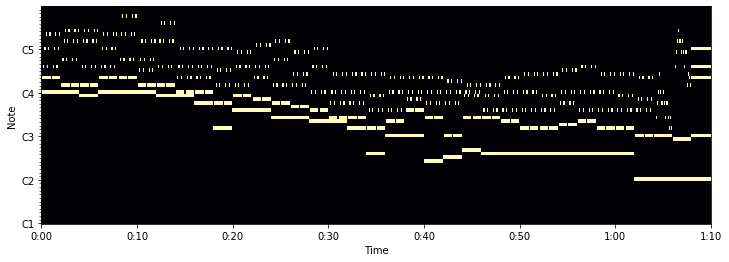

In [5]:
#钢琴滚动分布图（get_piano_roll函数返回的是ndarray，相关参数参考jupyter文档）
import librosa.display
def plot_bachpiano_roll(pm,start_pitch,end_pitch,fs=100):
    '''Display a spectrogram/chromagram/cqt/etc.'''
    librosa.display.specshow(pm.get_piano_roll(fs)[start_pitch:end_pitch],
                             x_axis='time',y_axis='cqt_note',sr=fs,hop_length=1,
                             fmin=pretty_midi.note_number_to_hz(start_pitch))    
#图像初始化
plt.figure(figsize=(12,4)) # width, height in inches
plot_bachpiano_roll(pm,24,84) # 24对应音名C1,84对应音名C6
#图像显示
plt.show()

In [76]:
def tq(track):
    notes_pitch=[]#建空列表
    notes_start=[]
    instrument = pm.instruments[track] #pm.instruments返回 mid文件的轨道，upper为钢琴右手的谱子旋律，lower为左手
    for note in instrument.notes:#音符参数是pitch音高，start和end time
        notes_pitch.append(note.pitch)
        notes_start.append(note.start)
    return notes_pitch,notes_start

def output(track):
    a=tq(track)
    import pandas as pd
    dataf={'Pitch':a[0],'Start Time':a[1]}
    r1=pd.DataFrame(dataf)
    return r1

output(1).to_excel('notes.xlsx',sheet_name='Right')
output(0).to_excel('notes.xlsx',sheet_name='Left')


### 4. 找出曲子的最高音和最低音
**pitch number和notes音名之间的转化函数：**  
pretty_midi.note_name_to_number('C-1')  把音名转化为编码
pretty_midi.note_number_to_name(0)  把编码转化为音名

In [6]:
#找出最高最低音
def notesmin(track):
    notes_pitch=[]#建空列表
    notes_start=[]
    instrument = pm.instruments[track] #pm.instruments返回 mid文件的轨道，upper为钢琴右手的谱子旋律，lower为左手
    for note in instrument.notes:#音符参数是pitch音高，start和end time
        notes_pitch.append(note.pitch)
        notes_start.append(note.start)
    minnote=min(notes_pitch)
    maxnote=max(notes_pitch)
    return minnote,maxnote #找出pitch的最大值和最小值（音高是按 number存储的，0-127表示88个音，参考钢琴大字小字组表 from C-1 to G9）

print("The lowest pitch in the song is :",pretty_midi.note_number_to_name(min(notesmin(0)[0],notesmin(1)[0])))
print("The highest pitch in the song is :",pretty_midi.note_number_to_name(max(notesmin(0)[1],notesmin(1)[1])))

The lowest pitch in the song is : C2
The highest pitch in the song is : A5


### 5、演示写入新的pretty_midi事件，并实现播放（最高音和最低音、两只老虎开头）

#### （1）感受巴赫圣母颂的最高音和最低音

In [7]:
#把最低音和最高音写入新文件演示（为了播放，不仅可视化，而且可听，演讲时候可以直接切换jupyter演示）
yinfu=pretty_midi.PrettyMIDI(initial_tempo=80)#bpm单位beats per min
#添加乐器轨道，乐器按照program数字分配（比如大提琴 program number 42），原mid文件中会有乐器声音，但这边synthesize合成之后都变成正弦波的音色了
inst=pretty_midi.Instrument(program=42,is_drum=False,name='notes best') 
yinfu.instruments.append(inst)
#在轨道中添加音符（速度，音高,每个音符开始时间,每个音符结束时间）
velocity=100
for pitch,start,end in zip([min(notesmin(0)[0],notesmin(1)[0]),max(notesmin(0)[1],notesmin(1)[1])],[0,2],[2,4]): 
    inst.notes.append(pretty_midi.Note(velocity,pitch,start,end))#写入音符
#合成播放，这是IPython包下的
import IPython.display
IPython.display.Audio(yinfu.synthesize(fs=16000),rate=16000)
#高音来袭，耳机党小心～！

#### （2）两只老虎——写出mid文件到当地文件夹

In [8]:
#生成mid文件
import pretty_midi
tiger = pretty_midi.PrettyMIDI(initial_tempo=80)
#添加乐器轨道（比如大提琴 program number 42）
instcello = pretty_midi.Instrument(program=42, is_drum=False, name='Two tigers')
tiger.instruments.append(instcello)
#在轨道中添加音符（速度，音高,每个音符开始时间,每个音符结束时间）
velocity = 120
tgnotes=[48,50,52,48, 48,50,52,48, 52,53,55, 52,53,55, 55,57,55,53,52,48, 55,57,55,53,52,48, 50,43,48, 50,43,48]
tgstart=[0.1,0.5,0.9,1.3, 1.7,2.1,2.5,2.9, 3.3,3.7,4.1, 4.9,5.3,5.7, 6.5,6.8,6.9,7.2,7.3,7.7, 8.1,8.4,8.5,8.8,8.9,9.3, 9.7,10.1,10.5, 11.3,11.7,12.1]
tgend=[0.5,0.9,1.3,1.7, 2.1,2.5,2.9,3.3, 3.7,4.1,4.9, 5.3,5.7,6.5, 6.8,6.9,7.2,7.3,7.7,8.1, 8.4,8.5,8.8,8.9,9.3,9.7, 10.1,10.5,11.3, 11.7,12.1,12.9]
for pitch, start, end in zip(tgnotes,tgstart,tgend):
    instcello.notes.append(pretty_midi.Note(velocity, pitch, start, end))
#写出mid文件
tiger.write('cello-C-tiger.mid')
#播放mid文件
import IPython.display
IPython.display.Audio(tiger.synthesize(fs=16000), rate=32000) 

## （二）节拍可视化分析

### 1. 绘制所有节拍的直方图和重拍的散点图

拍点： [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.  34.5
 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.  41.5
 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5 48.  48.5
 49.  49.5 50.  50.5 51.  51.5 52.  52.5 53.  53.5 54.  54.5 55.  55.5
 56.  56.5 57.  57.5 58.  58.5 59.  59.5 60.  60.5 61.  61.5 62.  62.5
 63.  63.5 64.  64.5 65.  65.5 66.  66.5 67.  67.5 68.  68.5 69.  69.5]
重拍： [ 0.  2.  4.  6.  8. 10. 12. 14. 16. 18. 20. 22. 24. 26. 28. 30. 32. 34.
 36. 38. 40. 42. 44. 46. 48. 50. 52. 54. 56. 58. 60. 62. 64. 66. 68.]


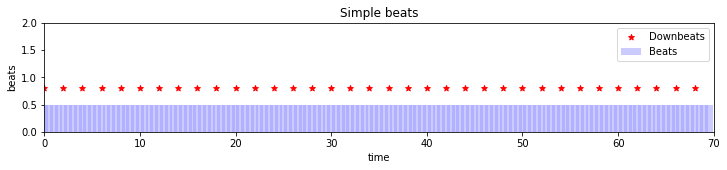

In [9]:
#节奏重拍图（有规律均匀分布)
print("拍点：",pm.get_beats())#返回的每个拍子的 start time
print("重拍：",pm.get_downbeats())#返回的重拍的 start time

#建立二元关系画图，把上面的所有拍点设为0.5，重拍是0.8
import matplotlib.pyplot as plt
a=[0.5]*len(pm.get_beats()) #len(pm.get_beats())=140
b=[0.8]*len(pm.get_downbeats()) #len(pm.get_downbeats())=35
plt.figure(figsize=(12,2))
plt.ylim(0,2)#y轴范围 0-2
plt.xlim(0,70)#x轴范围
plt.title('Simple beats')
plt.xlabel('time')
plt.ylabel('beats')
X=pm.get_downbeats() #重拍点所对应的 x轴 的位置
Y=b #重拍点所对应的 y轴 的位置
plt.scatter(X,Y,c='r',marker='*',label='Downbeats')#重拍的散点图，marker是点的样式
plt.bar(pm.get_beats(),a,facecolor='#9999ff',alpha=.5,label='Beats')#所有拍点的直方图，alpha是透明度
plt.legend(loc='upper right')#图例见右上角
plt.show()#显示图

### 2. 画出钢琴滚动矩阵图和重拍图（合二为一）

上面的直方图和散点图只是一个简单的节拍展示，那为了更直观的展示曲子的节拍的特点，下面将曲子的钢琴滚动矩阵和重拍合二为一画在一张图上展示。

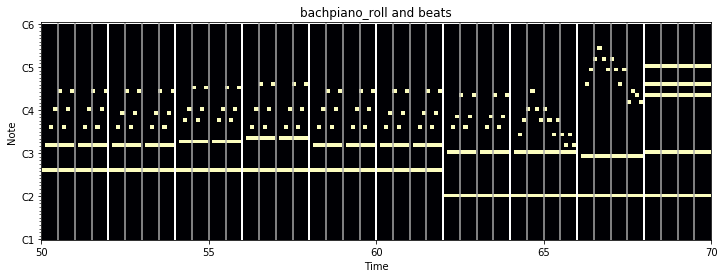

In [10]:
# 所有拍子和重拍
beats = pm.get_beats()
downbeats = pm.get_downbeats()
# 画出巴赫圣母颂 MIDI数据的钢琴滚动矩阵（仅显示20秒可清晰显示，所以分块画子图展示，设置函数代替语句重复）
plt.figure(figsize=(12, 4))
plot_bachpiano_roll(pm, 24, 84)
ymin, ymax = plt.ylim()
plt.title('bachpiano_roll and beats')
# 所有拍点为灰色线，重拍为白色线
import mir_eval.display
mir_eval.display.events(beats, base=ymin, height=ymax, color='#AAAAAA')
mir_eval.display.events(downbeats, base=ymin, height=ymax, color='#FFFFFF', lw=2)
# 为了清晰度，以其中20个小节为例展示
plt.xlim(50, 70)
plt.show()

## （三）音高可视化分析

### 1. 绘制每个音出现的频率直方图
**get_pitch_class_histogram**(use_duration=False, use_velocity=False, normalize=True)  
Computes the histogram of pitch classes.

由这个直方图可以看出主音C与属音G的出现次数远多于其他音。


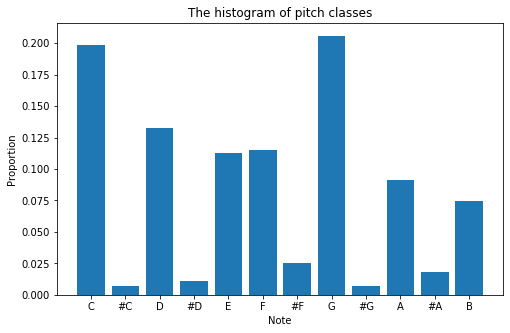

In [11]:
# 绘制音高等级分布的直方图-钢琴键盘每个音出现的频率
plt.figure(figsize=(8, 5))
plt.bar(np.arange(12), pm.get_pitch_class_histogram()) #这个内建函数返回的是每个音出现的频率直方图，需要画出来
plt.xticks(np.arange(12), ['C', '#C', 'D', '#D', 'E', 'F', '#F', 'G', '#G', 'A', '#A', 'B']) #x轴标签，按照全音、半音
plt.title('The histogram of pitch classes')
plt.xlabel('Note')
plt.ylabel('Proportion')
print("由这个直方图可以看出主音C与属音G的出现次数远多于其他音。")
plt.show()

### 2. 绘制左右手音符旋律音高图

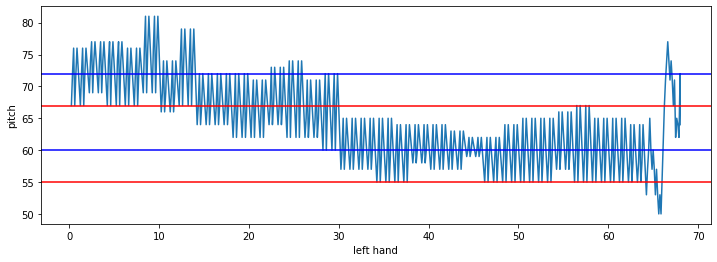

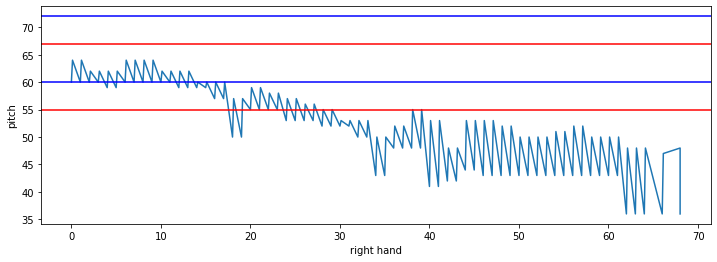

In [12]:
#单独提取左、右手音符，类似上面
def pickhand(track):
    notes_pitch=[]
    notes_start=[]
    instrument = pm.instruments[track]
    for note in instrument.notes:
        notes_pitch.append(note.pitch)
        notes_start.append(note.start)
    plt.figure(figsize=(12,4))
    plt.plot(notes_start, notes_pitch)
    plt.ylabel('pitch')
    plt.axhline(y=67, color='r', linestyle='-')#这边希望一根线上下移动，参考animotion包
    plt.axhline(y=55, color='r', linestyle='-')
    plt.axhline(y=72, color='b', linestyle='-')
    plt.axhline(y=60, color='b', linestyle='-')
pickhand(0) #左手
plt.xlabel('left hand')
pickhand(1) #右手
plt.xlabel('right hand')
plt.show()

纵轴为音高，其中蓝横线表示主音C，红线表示属音G。

# 二、wav文件处理，用musescore转换的格式

In [13]:
import librosa
import librosa.display

## （一）绘制音频的节拍色谱图
**chroma_cqt**(y=None, sr=22050, C=None, hop_length=512, fmin=None, norm=inf, threshold=0.0, tuning=None, n_chroma=12, n_octaves=7, window=None, bins_per_octave=None, cqt_mode='full')  
    Constant-Q chromagram

**beat_track**(y=None, sr=22050, onset_envelope=None, hop_length=512, start_bpm=120.0, tightness=100, trim=True, bpm=None, prior=None, units='frames')  
    Dynamic programming beat tracker.
    
**fix_frames**(frames, x_min=0, x_max=None, pad=True)  
    Fix a list of frames to lie within [x_min, x_max]  

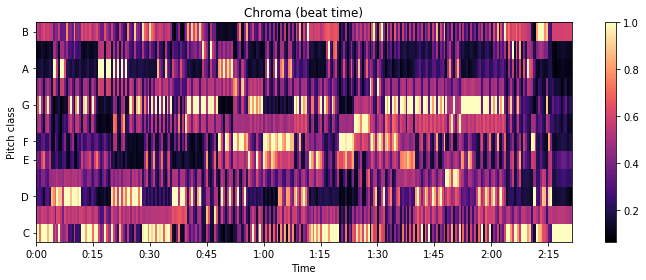

In [78]:
#Draw beat-synchronous chroma in natural time 要用到 wav格式的文件
import librosa
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 4))
y,sr=librosa.load('prelude1wav.wav',sr=None)
C = librosa.feature.chroma_cqt(y=y, sr=sr) #CQT chromagram色谱图
tempo, beat_f = librosa.beat.beat_track(y=y, sr=sr, trim=False)
beat_f = librosa.util.fix_frames(beat_f, x_max=C.shape[1])
Csync = librosa.util.sync(C, beat_f, aggregate=np.median)
beat_t = librosa.frames_to_time(beat_f, sr=sr)
librosa.display.specshow(Csync, y_axis='chroma', x_axis='time', x_coords=beat_t)
plt.title('Chroma (beat time)')
plt.tight_layout()
plt.colorbar()

## （二）古典音乐和流行音乐的波形图、频谱图、节拍强度图对比
### 除了听觉感官之外，从可视化角度对比凸显出以巴赫平均律钢琴曲集为代表的古典音乐的工整均匀优美性。

In [15]:
#两个 wav文件的读取
import librosa
import librosa.display
import matplotlib.pyplot as plt
y,sr=librosa.load('prelude1wav.wav',sr=None) #wav格式音频数据，读取 时间序列和保持原始采样率
y2,sr2=librosa.load('Mry_MixPart_Deep In The Fall.wav',sr=None) #读取我们自己编写录制的流行音乐声音 wav文件



### 1. 声音波形图对比

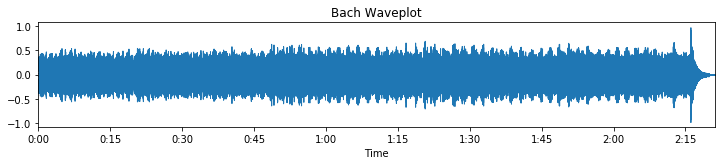

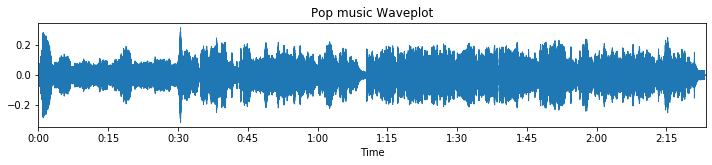

In [30]:
#绘制巴赫圣母颂和自己音乐的声音波形图
def getwave(no,y,sr,title):
    plt.figure(figsize=(10,4))
    plt.subplot(2, 1, no)
    librosa.display.waveplot(y,sr)
    plt.title(title)
    plt.tight_layout()
    plt.show()
getwave(1,y,sr,"Bach Waveplot")
getwave(2,y2,sr2,"Pop music Waveplot")


### 2. 声音频谱图对比

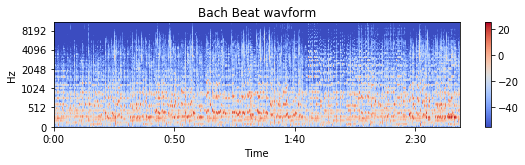

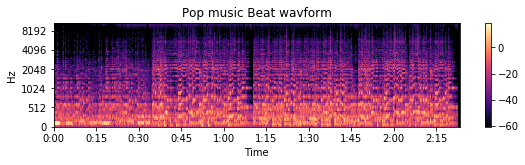

In [77]:

#巴赫圣母颂的频谱图
def pinpu(y,sr,title,no):
    plt.figure(figsize=(8,4))
    plt.subplot(2, 1, no)
    melspec = librosa.feature.melspectrogram(y, sr, n_fft=1024, hop_length=512, n_mels=128)#获取频谱图的特征值
    logmelspec = librosa.power_to_db(melspec)#convert to log scale
    librosa.display.specshow(logmelspec, sr=sr, x_axis='time', y_axis='mel')
    plt.title(title)
    plt.tight_layout()
    plt.colorbar()
pinpu(y,sr,'Bach Beat wavform',1)
pinpu(y2,sr2,'Pop music Beat wavform',2)
#自己编写流行音乐的声音波形图





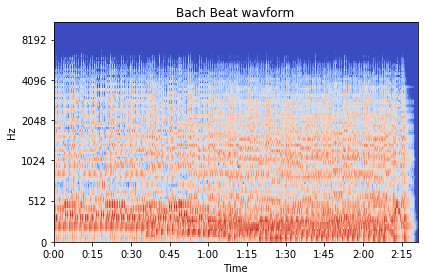

In [24]:
melspec = librosa.feature.melspectrogram(y, sr, n_fft=1024, hop_length=512, n_mels=128)#获取频谱图的特征值
logmelspec = librosa.power_to_db(melspec)#convert to log scale
librosa.display.specshow(logmelspec, sr=sr, x_axis='time', y_axis='mel')
plt.title('Bach Beat wavform')
plt.tight_layout()

plt.tight_layout()
plt.colorbar()

### 3. 节拍强度图对比

**librosa.onset.onset_strength**(y=None, sr=22050, S=None, lag=1, max_size=1, ref=None, detrend=False, center=True, feature=None, aggregate=None, centering=None, **kwargs)  
Compute a spectral flux onset strength envelope. 

**librosa.core.times_like**(X, sr=22050, hop_length=512, n_fft=None, axis=-1)  
Return an array of time values to match the time axis from a feature matrix.

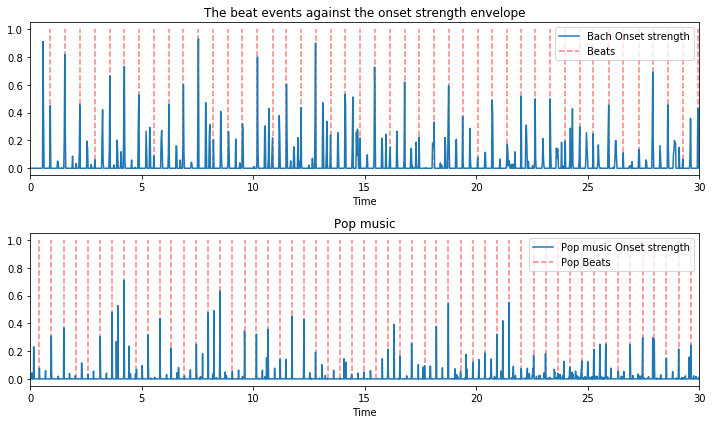

In [46]:
import matplotlib.pyplot as plt
hop_length = 512 #根据强度包络线绘制节拍强度图
plt.figure(figsize=(10, 6)) 

#巴赫圣母颂的节拍强度图
plt.subplot(2, 1, 1)
onset_env = librosa.onset.onset_strength(y, sr=sr,aggregate=np.median)
times = librosa.times_like(onset_env, sr=sr, hop_length=hop_length)
plt.plot(times, librosa.util.normalize(onset_env),label='Bach Onset strength')
plt.vlines(times[beats],0, 1, alpha=0.5, color='r',linestyle='--', label='Beats')
plt.title('The beat events against the onset strength envelope')
plt.xlabel('Time')
plt.legend(loc=1)
plt.xlim(0, 30)


#自己编写流行音乐的节拍强度图
tempo2, beat_f2 = librosa.beat.beat_track(y=y2, sr=sr2, trim=False)
plt.subplot(2, 1, 2)
onset_env2 = librosa.onset.onset_strength(y2, sr=sr2,aggregate=np.median)

times2 = librosa.times_like(onset_env2, sr=sr2, hop_length=hop_length)
plt.plot(times2, librosa.util.normalize(onset_env2),label='Pop music Onset strength')
plt.vlines(times2[beat_f2], 0, 1, alpha=0.5, color='r',linestyle='--', label='Pop Beats')
plt.title('Pop music')
plt.xlabel('Time')
plt.legend(loc=1)
plt.xlim(0, 30)
plt.gca().xaxis.set_major_formatter(librosa.display.TimeFormatter())
plt.tight_layout()
plt.show()



<Figure size 432x288 with 0 Axes>

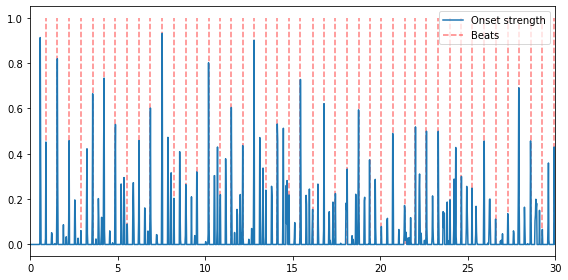

In [34]:
#绘制声音波形
import librosa
import librosa.display
y,sr=librosa.load('./2.wav')#音频数据，时间序列和压缩频率
tempo, beats = librosa.beat.beat_track(y=y, sr=sr)#返回的是tempo和beat的两个数组
melspec = librosa.feature.melspectrogram(y, sr, n_fft=1024, hop_length=512, n_mels=128)#获取频谱图的特征值
logmelspec = librosa.power_to_db(melspec)#convert to log scale
plt.figure()
onset_env = librosa.onset.onset_strength(y, sr=sr,aggregate=np.median)
import matplotlib.pyplot as plt
hop_length = 512
plt.figure(figsize=(8, 4))
times = librosa.times_like(onset_env, sr=sr, hop_length=hop_length)#??
plt.plot(times, librosa.util.normalize(onset_env),label='Onset strength')
plt.vlines(times[beats], 0, 1, alpha=0.5, color='r',linestyle='--', label='Beats')
plt.legend(frameon=True, framealpha=0.75)
# Limit the plot to a 15-second window
plt.xlim(0, 30)
plt.gca().xaxis.set_major_formatter(librosa.display.TimeFormatter())
plt.tight_layout()
plt.show()
